# Questions

1. Is it OK to initialize all the weights to the same value as long as that value is selected randomly using He initialization?
<br>No, because that would make the variance of the weights 0, and not 1, like we want if we want to avoid the vanishing/exploding gradients problem. 
"Doing this causes all the neurons in a layer to have the same value, which means they will never change. This is like having one neuron per layer, only much slower."
We need to break symmetry, that's why we initialize weights randomly. 

2. Is it OK to initialize the bias terms to 0?
<br> theoretically, I'd say so because as long as the inputs of the neurons have variance 1 and mean 0, you're good on the vanishing/exploding gradient problem. 

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import keras_tuner as kt

from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout

from sklearn.model_selection import train_test_split

import time

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)

X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

# EDA

In [9]:
import seaborn as sns
pd.value_counts(y_valid.flatten()) / len(y_valid.flatten())

6    0.1041
1    0.1026
7    0.1013
5    0.1008
0    0.1005
3    0.1001
2    0.1000
8    0.0993
9    0.0961
4    0.0952
dtype: float64

In [10]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

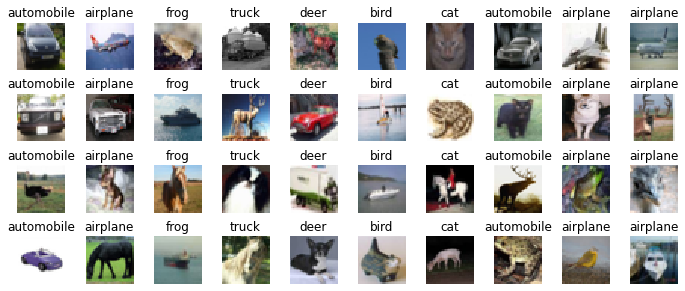

In [11]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train.flatten()[index%10]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
# plt.save_fig('digits_mnist_plot', tight_layout=False)
plt.show()

# 8 - Train a DNN on the CIFAR10 dataset

## 8.b- DNN, 20 layers, 100 neurons, He initialization, ELU

In [12]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/chapter-11-8a-lr-nadam'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [13]:
# setup LR scheduler
# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.1, 
    decay_steps = 5, 
    decay_rate = 0.5, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer='he_normal'))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

In [15]:
# setup optimizer
# optimizer = keras.optimizers.SGD(momentum=0.8)
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
optimizer = keras.optimizers.Nadam(learning_rate=1e-5)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [76]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb, lr_scheduler],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
1250/1250 [==============================] - 24s 15ms/step - loss: 11278338048.0000 - accuracy: 0.1009 - val_loss: 9.1141 - val_accuracy: 0.1032 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
1250/1250 [==============================] - 21s 17ms/step - loss: 4.6497 - accuracy: 0.1004 - val_loss: 5.0133 - val_accuracy: 0.0969 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
1250/1250 [==============================] - 15s 12ms/step - loss: 76.7076 - accuracy: 0.1003 - val_loss: 2.8532 - val_accuracy: 0.1032 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
1250/1250 [==============================] - 15s 12ms/step - loss: 3.5214 - accuracy: 0.0974 - val_loss: 4.4451 - val_accuracy: 0.1037 - lr: 0.1000

Epoch 5: LearningRateScheduler setting l

KeyboardInterrupt: 

### Find optimal learning rate

In [50]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/lr-optimizer'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# setup LR scheduler
# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-6, 
    decay_steps = 1, 
    decay_rate = 2, 
    staircase=True
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
# model.add(keras.layers.BatchNormalization())
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer='he_normal'))
#     model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.Nadam()

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=16, 
    validation_data=(X_valid, y_valid),
    callbacks=[tensorboard_cb, lr_scheduler],
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999974752427e-07.
Epoch 1/16
1250/1250 [==============================] - 25s 15ms/step - loss: 2.4861 - accuracy: 0.1454 - val_loss: 2.2745 - val_accuracy: 0.1725 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 2/16
1250/1250 [==============================] - 16s 13ms/step - loss: 2.1508 - accuracy: 0.2116 - val_loss: 2.0698 - val_accuracy: 0.2389 - lr: 2.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 3.999999989900971e-06.
Epoch 3/16
1250/1250 [==============================] - 17s 14ms/step - loss: 2.0033 - accuracy: 0.2702 - val_loss: 1.9575 - val_accuracy: 0.2930 - lr: 4.0000e-06

Epoch 4: LearningRateScheduler setting learning rate to 7.999999979801942e-06.
Epoch 4/16
1250/1250 [==============================] - 17s 13ms/step - loss: 1.9048 - accuracy: 0.3164 - val_loss: 1.8697 - val_accuracy: 0.3250 - lr: 8.0000e-06

Epoch 5: LearningRateSched

Text(0, 0.5, 'Loss')

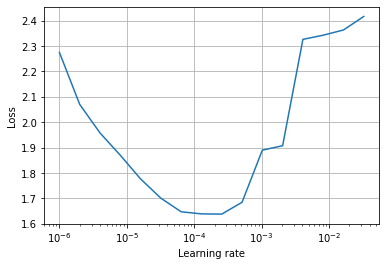

In [51]:
plt.plot(history.history['lr'], history.history['val_loss'])
plt.gca().set_xscale('log')
# plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
# plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [52]:
history.history['lr']

[1e-06,
 2e-06,
 4e-06,
 8e-06,
 1.6e-05,
 3.2e-05,
 6.4e-05,
 0.000128,
 0.000256,
 0.000512,
 0.001024,
 0.002048,
 0.004096,
 0.008192,
 0.016384,
 0.032768]

### Use optimal rate

In [ ]:
optimal_rate = 2.5e-4 #0.000256

In [55]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/optimal-rate'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# create model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer='he_normal'))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.Nadam(learning_rate=optimal_rate)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

# train
history = model.fit(
    X_train, 
    y_train, 
    epochs=13, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb],
)

Epoch 1/13
1250/1250 [==============================] - 29s 16ms/step - loss: 1.9775 - accuracy: 0.2855 - val_loss: 1.7913 - val_accuracy: 0.3514
Epoch 2/13
1250/1250 [==============================] - 19s 15ms/step - loss: 1.7660 - accuracy: 0.3602 - val_loss: 1.6860 - val_accuracy: 0.3882
Epoch 3/13
1250/1250 [==============================] - 18s 14ms/step - loss: 1.6724 - accuracy: 0.3977 - val_loss: 1.6409 - val_accuracy: 0.4163
Epoch 4/13
1250/1250 [==============================] - 16s 13ms/step - loss: 1.6070 - accuracy: 0.4245 - val_loss: 1.6523 - val_accuracy: 0.4072
Epoch 5/13
1250/1250 [==============================] - 16s 13ms/step - loss: 1.5563 - accuracy: 0.4415 - val_loss: 1.6175 - val_accuracy: 0.4179
Epoch 6/13
1250/1250 [==============================] - 20s 16ms/step - loss: 1.5160 - accuracy: 0.4593 - val_loss: 1.5697 - val_accuracy: 0.4319
Epoch 7/13
1250/1250 [==============================] - 16s 12ms/step - loss: 1.4793 - accuracy: 0.4699 - val_loss: 1.5859 -

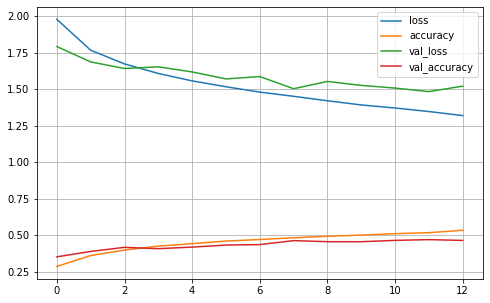

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [61]:
optimal_rate = 2.5e-4 / 10 #0.000256

In [62]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/optimal-rate-2'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# create model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer='he_normal'))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.Nadam(learning_rate=optimal_rate)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

# train
history = model.fit(
    X_train, 
    y_train, 
    epochs=13, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb],
)

Epoch 1/13
1250/1250 [==============================] - 29s 15ms/step - loss: 1.9970 - accuracy: 0.2821 - val_loss: 1.8241 - val_accuracy: 0.3367
Epoch 2/13
1250/1250 [==============================] - 15s 12ms/step - loss: 1.7626 - accuracy: 0.3663 - val_loss: 1.7212 - val_accuracy: 0.3756
Epoch 3/13
1250/1250 [==============================] - 18s 14ms/step - loss: 1.6737 - accuracy: 0.3969 - val_loss: 1.6597 - val_accuracy: 0.3998
Epoch 4/13
1250/1250 [==============================] - 18s 14ms/step - loss: 1.6145 - accuracy: 0.4197 - val_loss: 1.6286 - val_accuracy: 0.4161
Epoch 5/13
 557/1250 [============>.................] - ETA: 8s - loss: 1.5687 - accuracy: 0.4371

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### Use Nesterov Accelerated Gradient

In [108]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/nesterov'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# create model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer='he_normal'))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.SGD(optimal_rate, momentum=0.9, nesterov=True)
# optimizer = keras.optimizers.Nadam(learning_rate=optimal_rate)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

# train
history = model.fit(
    X_train, 
    y_train, 
    epochs=15, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb],
)

Epoch 1/15
1250/1250 [==============================] - 10s 7ms/step - loss: 2.1207 - accuracy: 0.2356 - val_loss: 1.9630 - val_accuracy: 0.2780
Epoch 2/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9131 - accuracy: 0.3086 - val_loss: 1.9026 - val_accuracy: 0.3057
Epoch 3/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.8467 - accuracy: 0.3327 - val_loss: 1.8271 - val_accuracy: 0.3369
Epoch 4/15
1250/1250 [==============================] - 7s 5ms/step - loss: 1.8001 - accuracy: 0.3508 - val_loss: 1.7912 - val_accuracy: 0.3526
Epoch 5/15
1250/1250 [==============================] - 9s 8ms/step - loss: 1.7647 - accuracy: 0.3670 - val_loss: 1.7793 - val_accuracy: 0.3595
Epoch 6/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7337 - accuracy: 0.3779 - val_loss: 1.7405 - val_accuracy: 0.3736
Epoch 7/15
1250/1250 [==============================] - 7s 5ms/step - loss: 1.7063 - accuracy: 0.3884 - val_loss: 1.7332 - val_accuracy

Observation: Training time is significantly faster using Nesterov. Ultimately, the bias of the resulting model is higher for SGD w/ Nesterov than Nadam. Not sure why that is. I guess SGD w/ Nesterov didn't take us to the global minimum as fast, but it seems like it would have, based on the tensorboard plots. So Nadam is just faster, I guess. 

## 8.c - Batch Normalization

In [71]:
class TimeHistory(keras.callbacks.Callback):
    import time
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [77]:
# tensorboard callback
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/batch-norm'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# time callback
time_callback = TimeHistory()

# create model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
model.add(keras.layers.BatchNormalization())
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.Nadam(learning_rate=optimal_rate)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

# train
history = model.fit(
    X_train, 
    y_train, 
    epochs=25, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb, time_callback],
)

Epoch 1/25
1250/1250 [==============================] - 35s 19ms/step - loss: 2.4139 - accuracy: 0.1762 - val_loss: 2.1474 - val_accuracy: 0.2388
Epoch 2/25
1250/1250 [==============================] - 30s 24ms/step - loss: 2.0896 - accuracy: 0.2562 - val_loss: 1.9616 - val_accuracy: 0.2972
Epoch 3/25
1250/1250 [==============================] - 28s 22ms/step - loss: 1.9623 - accuracy: 0.2999 - val_loss: 1.8671 - val_accuracy: 0.3332
Epoch 4/25
1250/1250 [==============================] - 23s 18ms/step - loss: 1.8832 - accuracy: 0.3262 - val_loss: 1.7913 - val_accuracy: 0.3614
Epoch 5/25
1250/1250 [==============================] - 20s 16ms/step - loss: 1.8252 - accuracy: 0.3485 - val_loss: 1.7400 - val_accuracy: 0.3779
Epoch 6/25
1250/1250 [==============================] - 20s 16ms/step - loss: 1.7709 - accuracy: 0.3685 - val_loss: 1.6919 - val_accuracy: 0.4001
Epoch 7/25
1250/1250 [==============================] - 20s 16ms/step - loss: 1.7335 - accuracy: 0.3838 - val_loss: 1.6638 -

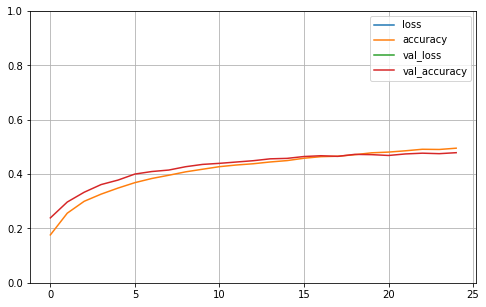

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [79]:
print([np.mean(time_callback.times), np.std(time_callback.times)])

[21.746672554016115, 3.6602331082633226]


### Batch Normalization with activation after normalization

In [80]:
# tensorboard callback
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/batch-norm-2'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# time callback
time_callback = TimeHistory()

# create model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
model.add(keras.layers.BatchNormalization())
for layer in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('elu'))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.Nadam(learning_rate=optimal_rate)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

# train
history = model.fit(
    X_train, 
    y_train, 
    epochs=25, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb, time_callback],
)

Epoch 1/25
1250/1250 [==============================] - 35s 17ms/step - loss: 2.1906 - accuracy: 0.2206 - val_loss: 1.9431 - val_accuracy: 0.2981
Epoch 2/25
1250/1250 [==============================] - 25s 20ms/step - loss: 1.9016 - accuracy: 0.3168 - val_loss: 1.7921 - val_accuracy: 0.3499
Epoch 3/25
1250/1250 [==============================] - 24s 19ms/step - loss: 1.8016 - accuracy: 0.3526 - val_loss: 1.7159 - val_accuracy: 0.3821
Epoch 4/25
1250/1250 [==============================] - 26s 21ms/step - loss: 1.7389 - accuracy: 0.3809 - val_loss: 1.6536 - val_accuracy: 0.4081
Epoch 5/25
1250/1250 [==============================] - 18s 15ms/step - loss: 1.6913 - accuracy: 0.3970 - val_loss: 1.6274 - val_accuracy: 0.4189
Epoch 6/25
1250/1250 [==============================] - 21s 17ms/step - loss: 1.6531 - accuracy: 0.4105 - val_loss: 1.5977 - val_accuracy: 0.4330
Epoch 7/25
1250/1250 [==============================] - 22s 18ms/step - loss: 1.6181 - accuracy: 0.4244 - val_loss: 1.5730 -

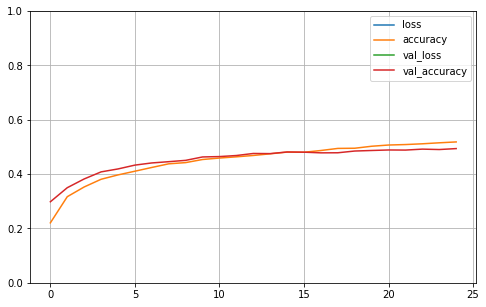

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Using the activation after batch normalization (so inbetween the activation function and the output alpha) results in a better performance than using the batch normalization after the activation function.

## 8.d - SELU activation

In [82]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/selu'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# create model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
model.add(keras.layers.Normalization())
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer='lecun_normal'))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.Nadam(learning_rate=optimal_rate)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

# train
history = model.fit(
    X_train, 
    y_train, 
    epochs=20, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb],
)

Epoch 1/20
1250/1250 [==============================] - 21s 12ms/step - loss: 1.9476 - accuracy: 0.2908 - val_loss: 1.7972 - val_accuracy: 0.3501
Epoch 2/20
1250/1250 [==============================] - 15s 12ms/step - loss: 1.7460 - accuracy: 0.3729 - val_loss: 1.6945 - val_accuracy: 0.3855
Epoch 3/20
1250/1250 [==============================] - 14s 11ms/step - loss: 1.6602 - accuracy: 0.4044 - val_loss: 1.6509 - val_accuracy: 0.4039
Epoch 4/20
1250/1250 [==============================] - 15s 12ms/step - loss: 1.6028 - accuracy: 0.4256 - val_loss: 1.6071 - val_accuracy: 0.4136
Epoch 5/20
1250/1250 [==============================] - 14s 11ms/step - loss: 1.5619 - accuracy: 0.4429 - val_loss: 1.5732 - val_accuracy: 0.4284
Epoch 6/20
1250/1250 [==============================] - 14s 11ms/step - loss: 1.5276 - accuracy: 0.4527 - val_loss: 1.5683 - val_accuracy: 0.4339
Epoch 7/20
1250/1250 [==============================] - 13s 10ms/step - loss: 1.4984 - accuracy: 0.4634 - val_loss: 1.5388 -

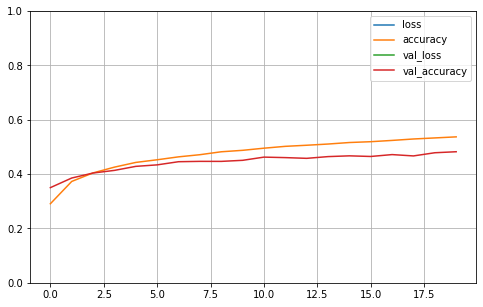

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## 8.e - Dropout (alpha dropout)

In [86]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/alpha-dropout'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# create model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
model.add(keras.layers.Normalization())
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer='lecun_normal'))
model.add(keras.layers.AlphaDropout(0.2))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.Nadam(learning_rate=optimal_rate)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

# train
history = model.fit(
    X_train, 
    y_train, 
    epochs=15, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb],
)

Epoch 1/15
1250/1250 [==============================] - 21s 13ms/step - loss: 2.1594 - accuracy: 0.2290 - val_loss: 1.8668 - val_accuracy: 0.3450
Epoch 2/15
1250/1250 [==============================] - 14s 11ms/step - loss: 1.8702 - accuracy: 0.3322 - val_loss: 1.7501 - val_accuracy: 0.3839
Epoch 3/15
1250/1250 [==============================] - 14s 11ms/step - loss: 1.7529 - accuracy: 0.3705 - val_loss: 1.7175 - val_accuracy: 0.3947
Epoch 4/15
1250/1250 [==============================] - 13s 11ms/step - loss: 1.6848 - accuracy: 0.3952 - val_loss: 1.7260 - val_accuracy: 0.3953
Epoch 5/15
1250/1250 [==============================] - 13s 11ms/step - loss: 1.6359 - accuracy: 0.4132 - val_loss: 1.6368 - val_accuracy: 0.4283
Epoch 6/15
1250/1250 [==============================] - 14s 11ms/step - loss: 1.5981 - accuracy: 0.4273 - val_loss: 1.6822 - val_accuracy: 0.4262
Epoch 7/15
1250/1250 [==============================] - 14s 11ms/step - loss: 1.5678 - accuracy: 0.4397 - val_loss: 1.6032 -

### Check validation accuracy using alpha dropout, and MC dropout

In [89]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 4s 13ms/step - loss: 1.5707 - accuracy: 0.4749


[1.5707290172576904, 0.4749000072479248]

In [91]:
y_probas = np.stack([model(X_test, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [107]:
accuracy = np.sum(np.argmax(y_proba, axis=1) == y_test.flatten()) / len(y_proba)
print(accuracy)

0.4759


Slight improvement using MC dropout. 

## 8.f Learning Rate Schedules

### 1 - Exponential

In [ ]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/8f-learning-rate-schedules-1'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# setup LR scheduler
# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = optimal_rate * 10, 
    decay_steps = 5, 
    decay_rate = 0.1, 
    staircase=False
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

# create model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
model.add(keras.layers.Normalization())
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer='lecun_normal'))
model.add(keras.layers.AlphaDropout(0.2))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.Nadam(learning_rate=optimal_rate)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

# train
history = model.fit(
    X_train, 
    y_train, 
    epochs=15, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb, lr_scheduler],
)

Using an exponential decay schedule results in a similar convergence time as the constant optimal learning rate, based on the tensorboard plots. 

### 2 - 1cycle scheduling

In [37]:
import math

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    
    
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [24]:
tf.random.set_seed(42)
np.random.seed(42)

#### Find Learning Rate

In [38]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/1cycle'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

313/313 [==============================] - 4s 12ms/step - loss: 5538.9019 - accuracy: 0.1141


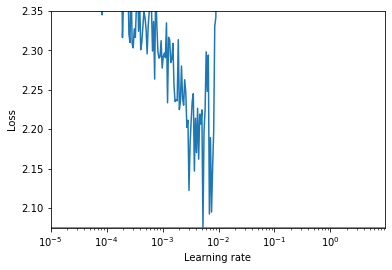

In [39]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [40]:
n_epochs = 50
batch_size = 128

# history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
#                     validation_data=(X_valid_scaled, y_valid),
#                     callbacks=[onecycle])

# onecycle learning rate scheduler callback
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)

# train
history = model.fit(
    X_train, 
    y_train, 
    epochs=n_epochs, 
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[tensorboard_cb, onecycle],
)

Epoch 1/50
313/313 [==============================] - 4s 13ms/step - loss: 2.0146 - accuracy: 0.2774 - val_loss: 2.2594 - val_accuracy: 0.1821
Epoch 2/50
313/313 [==============================] - 3s 10ms/step - loss: 1.8759 - accuracy: 0.3358 - val_loss: 1.8108 - val_accuracy: 0.3622
Epoch 3/50
313/313 [==============================] - 3s 11ms/step - loss: 1.8367 - accuracy: 0.3485 - val_loss: 1.8113 - val_accuracy: 0.3613
Epoch 4/50
313/313 [==============================] - 3s 10ms/step - loss: 1.8080 - accuracy: 0.3605 - val_loss: 1.8776 - val_accuracy: 0.3288
Epoch 5/50
313/313 [==============================] - 3s 9ms/step - loss: 1.7813 - accuracy: 0.3707 - val_loss: 1.8319 - val_accuracy: 0.3633
Epoch 6/50
313/313 [==============================] - 4s 13ms/step - loss: 1.7450 - accuracy: 0.3856 - val_loss: 1.9755 - val_accuracy: 0.3356
Epoch 7/50
313/313 [==============================] - 5s 16ms/step - loss: 1.7039 - accuracy: 0.3971 - val_loss: 1.9765 - val_accuracy: 0.3128


SPeed of training per epoch is greatly improved (down to < 10s)

#### Normalize Input

In [52]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [53]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/1cycle-scaled'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

313/313 [==============================] - 3s 9ms/step - loss: 509298016.0000 - accuracy: 0.1142


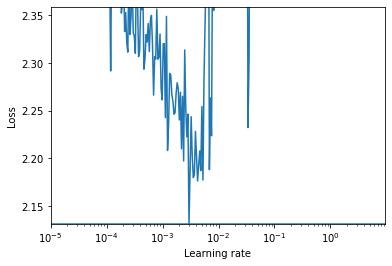

In [54]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [55]:
n_epochs = 50
batch_size = 128

# onecycle learning rate scheduler callback
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)

# train
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=n_epochs, 
    batch_size=batch_size,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[tensorboard_cb, onecycle],
)

Epoch 1/50
313/313 [==============================] - 4s 14ms/step - loss: 1.8690 - accuracy: 0.3501 - val_loss: 1.7178 - val_accuracy: 0.3921
Epoch 2/50
313/313 [==============================] - 4s 12ms/step - loss: 1.6397 - accuracy: 0.4252 - val_loss: 1.6546 - val_accuracy: 0.4165
Epoch 3/50
313/313 [==============================] - 4s 12ms/step - loss: 1.5511 - accuracy: 0.4566 - val_loss: 1.5785 - val_accuracy: 0.4494
Epoch 4/50
313/313 [==============================] - 3s 10ms/step - loss: 1.4857 - accuracy: 0.4805 - val_loss: 1.6233 - val_accuracy: 0.4418
Epoch 5/50
313/313 [==============================] - 3s 9ms/step - loss: 1.4313 - accuracy: 0.5018 - val_loss: 1.5868 - val_accuracy: 0.4513
Epoch 6/50
313/313 [==============================] - 3s 9ms/step - loss: 1.3801 - accuracy: 0.5164 - val_loss: 1.5423 - val_accuracy: 0.4593
Epoch 7/50
313/313 [==============================] - 3s 9ms/step - loss: 1.3395 - accuracy: 0.5310 - val_loss: 1.4554 - val_accuracy: 0.4879
Ep

Greatly improved accuracy from normalizing the inputs!!!

#### l1 + using functools.partial to compact NN code

In [60]:
n_epochs = 25
batch_size = 128

# tensorboard
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/1cycle-l1'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# onecycle learning rate scheduler callback
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)

# model
from functools import partial
RegularizedDense = partial(
    keras.layers.Dense, 
   activation='selu', 
   kernel_initializer='lecun_normal', 
   kernel_regularizer=keras.regularizers.l1()
)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    RegularizedDense(300),
    RegularizedDense(100),
    keras.layers.Dense(10, activation="softmax", kernel_initializer='lecun_normal')
])

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

# train
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=n_epochs, 
    batch_size=batch_size,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[tensorboard_cb, onecycle],
)

Epoch 1/25
313/313 [==============================] - 5s 14ms/step - loss: 83.9789 - accuracy: 0.3365 - val_loss: 28.3932 - val_accuracy: 0.3403
Epoch 2/25
313/313 [==============================] - 3s 11ms/step - loss: 11.8819 - accuracy: 0.2745 - val_loss: 6.1687 - val_accuracy: 0.2209
Epoch 3/25
313/313 [==============================] - 4s 11ms/step - loss: 4.4383 - accuracy: 0.2150 - val_loss: 3.3383 - val_accuracy: 0.1990
Epoch 4/25
313/313 [==============================] - 3s 11ms/step - loss: 3.1461 - accuracy: 0.1870 - val_loss: 3.2971 - val_accuracy: 0.1518
Epoch 5/25
313/313 [==============================] - 3s 11ms/step - loss: 3.2836 - accuracy: 0.1822 - val_loss: 3.3635 - val_accuracy: 0.1885
Epoch 6/25
313/313 [==============================] - 3s 11ms/step - loss: 3.4734 - accuracy: 0.1837 - val_loss: 3.5798 - val_accuracy: 0.1876
Epoch 7/25
313/313 [==============================] - 3s 11ms/step - loss: 3.6678 - accuracy: 0.1822 - val_loss: 3.7893 - val_accuracy: 0.1

#### l2 + using functools.partial to compact NN code

In [56]:
n_epochs = 50
batch_size = 128

# tensorboard
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/1cycle-l2'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# onecycle learning rate scheduler callback
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)

# model
from functools import partial
RegularizedDense = partial(
    keras.layers.Dense, 
   activation='selu', 
   kernel_initializer='lecun_normal', 
   kernel_regularizer=keras.regularizers.l2(0.01)
)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    RegularizedDense(300),
    RegularizedDense(100),
    keras.layers.Dense(10, activation="softmax", kernel_initializer='lecun_normal')
])

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

# train
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=n_epochs, 
    batch_size=batch_size,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[tensorboard_cb, onecycle],
)

Performance improvement!!! Train + Validation are very close in tensorboard, so we successfully fought over-fitting. 

#### L1 + L2 

In [59]:
n_epochs = 50
batch_size = 128

# tensorboard
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/1cycle-l1-l2'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# onecycle learning rate scheduler callback
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)

# model
from functools import partial
RegularizedDense = partial(
    keras.layers.Dense, 
   activation='selu', 
   kernel_initializer='lecun_normal', 
   kernel_regularizer=keras.regularizers.l1_l2()
)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    RegularizedDense(300),
    RegularizedDense(100),
    keras.layers.Dense(10, activation="softmax", kernel_initializer='lecun_normal')
])

# compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

# train
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=n_epochs, 
    batch_size=batch_size,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[tensorboard_cb, onecycle],
)

Epoch 1/50
313/313 [==============================] - 6s 16ms/step - loss: 89.1026 - accuracy: 0.3350 - val_loss: 35.6135 - val_accuracy: 0.3447
Epoch 2/50
313/313 [==============================] - 5s 15ms/step - loss: 15.4163 - accuracy: 0.3178 - val_loss: 7.0598 - val_accuracy: 0.2522
Epoch 3/50
313/313 [==============================] - 4s 14ms/step - loss: 5.1790 - accuracy: 0.2448 - val_loss: 3.7617 - val_accuracy: 0.2508
Epoch 4/50
313/313 [==============================] - 4s 13ms/step - loss: 3.1105 - accuracy: 0.2634 - val_loss: 2.8540 - val_accuracy: 0.2528
Epoch 5/50
313/313 [==============================] - 4s 13ms/step - loss: 2.8356 - accuracy: 0.2763 - val_loss: 2.9094 - val_accuracy: 0.2587
Epoch 6/50
313/313 [==============================] - 4s 13ms/step - loss: 2.9250 - accuracy: 0.2806 - val_loss: 2.9738 - val_accuracy: 0.2747
Epoch 7/50
313/313 [==============================] - 4s 14ms/step - loss: 3.0160 - accuracy: 0.2810 - val_loss: 3.0695 - val_accuracy: 0.2

Ooh, too much regularization, it seems. Accuracy is quite low. Looks like we're under-fitting now. 